In [1]:
import numpy as np
import xarray as xr
import glob2 as glob
import matplotlib.pyplot as plt
import cmocean as cmo
from numpy import linalg as LA
from tqdm import tqdm
from util import skill_matrix, build_h_matrix, fill_h_matrix, reverse_vector, forecast_ssh 
from util import build_swath, inversion, make_error_over_time

In [2]:
# Constants and initializations
day0, day1 = 0, 40
Tdim = day1 - day0
time_range = 2 * Tdim
n_waves = '190'
MModes = 1
exp = 1  # P_over_R = K^-1
alpha_std = np.arange(5e-4, 3.05e-2, 1e-3)

# Load static data
avisso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')

lonidx_west, lonidx_east  =  60, 102
latidx_south, latidx_north = 34, 74

lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')
Psi = strat_ds.Psi.data
Omega = 7.27e-5
Earth_radius = 6.371e6 / 1e5
Phi0 = lat.mean()
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius


# Load wave files
wave_files = sorted(glob.glob('./rossby_wave_estimate_*_' + n_waves + 'waves_data40days.nc'))

# Initialize arrays
rms_err, rms_ssh, ssh_est_skill2, ssh_est_skill1 = [np.zeros((len(wave_files), len(alpha_std))) for _ in range(4)]

swath_width, x_swath = 6, 20
days = np.arange(day0, day1)
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

In [55]:
def fill_h_matrix(Tdim, left_valid, right_valid, Valid_points, xc1_valid, xc2_valid, H_, M):
    """
    Calculate the error basis function and fill the H matrix part.

    :param Tdim: Total dimension of the time range
    :param left_valid: Number of valid points on the left swath
    :param right_valid: Number of valid points on the right swath
    :param Valid_points: Total number of valid points
    :param xc1_valid: X-coordinate values for the left swath
    :param xc2_valid: X-coordinate values for the right swath
    :param H_swath: H matrix to be filled
    :param M: Number of models
    :return: Filled H_swath matrix
    """
    # sample SSH, errors and add white noise
    IND_TIMINGl = -7
    IND_ROLLl = -6
    IND_BASELINEl = -5
    IND_PHASE3l, IND_PHASE4l, IND_PHASE5l, IND_PHASE6l = -4, -3, -2, -1
    # sample SSH, errors and add white noise
    IND_TIMINGr = -7
    IND_ROLLr = -6
    IND_BASELINEr = -5
    IND_PHASE3r, IND_PHASE4r, IND_PHASE5r, IND_PHASE6r = -4, -3, -2, -1
    
    err_basis_func = np.zeros([len(xvalid_index), 7*2])


    for tt in range(Tdim):
        for ii in range(left_valid):
            #timing error
            err_basis_func[ii+tt*Valid_points, IND_TIMINGl] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
            # roll error = alpha[1] * Xc^1
            err_basis_func[ii+tt*Valid_points, IND_ROLLl] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
            # baseline dialation error = alpha[2] * Xc^2
            err_basis_func[ii+tt*Valid_points, IND_BASELINEl] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
            # phase error 
            H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
            H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
            err_basis_func[ii+tt*Valid_points, IND_PHASE3l] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
            err_basis_func[ii+tt*Valid_points, IND_PHASE4l] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
            err_basis_func[ii+tt*Valid_points, IND_PHASE5l] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
            err_basis_func[ii+tt*Valid_points, IND_PHASE6l] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)

    for tt in range(Tdim):
        for ii in range(left_valid, Valid_points):
            #timing error
            err_basis_func[ii+tt*Valid_points, IND_TIMINGr] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
            # roll error = alpha[1] * Xc^1
            err_basis_func[ii+tt*Valid_points, IND_ROLLr] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
            # baseline dialation error = alpha[2] * Xc^2
            err_basis_func[ii+tt*Valid_points, IND_BASELINEr] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
            # phase error 
            H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
            H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
            err_basis_func[ii+tt*Valid_points, IND_PHASE3r] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
            err_basis_func[ii+tt*Valid_points, IND_PHASE4r] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
            err_basis_func[ii+tt*Valid_points, IND_PHASE5r] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
            err_basis_func[ii+tt*Valid_points, IND_PHASE6r] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)

    for tt in range(Tdim):
        # print(2 * M + tt * 7 , 2 * M + (tt+1) * 7)
        H_[:, 2 * M + tt * 14 : 2 * M + (tt+1) * 14] = err_basis_func
        
    return H_

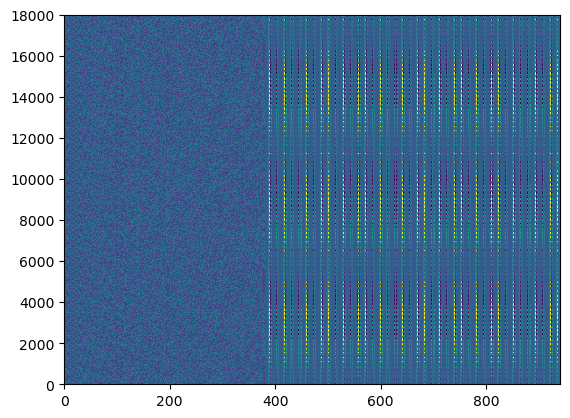

In [56]:
plt.pcolormesh(H_swath)

In [57]:
# Initialize arrays
rms_err, rms_ssh = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
ssh_est_skill2, err_est_skill2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
ssh_est_skill1, err_est_skill1 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

# Initialize arrays for storing forecasts and variance explained
SSHA_predicted = np.zeros( (len(wave_files), len(alpha_std), time_range, len(lat) * len(lon)))
SSHA_predicted1 = np.zeros( (len(wave_files), len(alpha_std), time_range, len(lat) * len(lon)))
variance_explained_1step = np.zeros((len(wave_files), len(alpha_std), time_range))
variance_explained_2step = np.zeros((len(wave_files),len(alpha_std), time_range))
residual_1step = np.zeros((len(wave_files), len(alpha_std), time_range))
residual_2step = np.zeros((len(wave_files),len(alpha_std), time_range))
MSLA_fwrd_1step = np.zeros((len(wave_files), len(alpha_std), time_range, len(lat), len(lon)))
MSLA_fwrd_2step = np.zeros((len(wave_files), len(alpha_std), time_range, len(lat), len(lon)))

# Initialize multi-dimensional arrays for storing variance explained
variance_explained_in_1step = np.zeros((len(wave_files), len(alpha_std), time_range))
variance_explained_out_1step = np.zeros((len(wave_files), len(alpha_std), time_range))
variance_explained_in_2step = np.zeros((len(wave_files), len(alpha_std), time_range))
variance_explained_out_2step = np.zeros((len(wave_files), len(alpha_std), time_range))

In [58]:
import numpy as np

def calculate_p_matrix(k_n, l_n, M, Tdim, sigma):
    """
    Calculates the P_matrix based on the given wavenumbers k_n and l_n, and other parameters.

    Args:
    k_n (array-like): Array of wavenumbers k.
    l_n (array-like): Array of wavenumbers l.
    M (int): Size parameter for matrix dimensions.
    Tdim (int): Additional dimension size.
    sigma (float): Standard deviation for error calculation.

    Returns:
    numpy.ndarray: The calculated P_matrix.
    """
    exp = -2
    k0 = l_n.max()  # flat at or below k0
    p_diagonal = np.zeros([2 * M + Tdim * 7 * 2])
    kl, kl_plot = np.zeros(M), np.zeros(2 * M)
    k_, l_ = np.zeros(len(l_n) * len(k_n)), np.zeros(len(l_n) * len(k_n))
    counter = 0
    R = 0.01  # noise = 1 cm

    for kk in k_n:
        for ll in l_n:
            k_[counter], l_[counter] = kk, ll
            kl[counter] = np.sqrt(kk ** 2 + ll ** 2)  # wavenumber
            kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
            counter += 1

    p_factor = .16 / kl[:M].sum()  # variance of the model, convert sum of variance from wavenumber to meter

    for i in range(M):
        p_diagonal[2 * i] = p_diagonal[2 * i + 1] = (kl[i] + k0) ** exp * p_factor

    p_diagonal[2 * M:] = sigma ** 2  # errors

    P_matrix = np.zeros([2 * M + Tdim * 7 * 2, 2 * M + Tdim * 7 * 2])
    np.fill_diagonal(P_matrix[:], R / p_diagonal)

    return P_matrix


In [ ]:
#### Sub-sample the SSH, correlated errors and H matrix
# Assuming wave_files is a list of file paths
with tqdm(total= rms_err.size) as pbar:
    for n, file_path in enumerate(wave_files[:1]):
        # Load data from the current file
        wave_ds = xr.open_dataset(file_path)
        amp = wave_ds.Amplitudes.data
        time= wave_ds.time.data
        MSLA_fwd = wave_ds.MSLA_forward.data
        Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree
        
        # Days since 2016-01-01
        since_2016Jan1 = np.datetime64('2016-01-01')
        end_date = np.datetime64(wave_files[0][23:33]) # Ensemble start date
        days_since_2016Jan1 = (end_date - since_2016Jan1).astype('timedelta64[D]').astype(int) # days since 2016-01-01
        T_time = avisso_ds.time.data[days_since_2016Jan1:] * 86400 # in seconds
        
        # Wavenumbers
        l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
        l_n = l_n_orig.reshape(len(l_n_orig), MModes)
        k_n = k_n_orig.reshape(len(k_n_orig), MModes)
        M = k_n.size * l_n.size # Number of models/waves

        counter = 0
        exp = -2
        ssh_std = .1
        k0 = l_n.max() # flat at or below k0
        
        kl, kl_plot = np.zeros(M), np.zeros(2*M)
        k_, l_ = np.zeros(M), np.zeros(M)
        counter = 0
        R = 0.01 # noise = 10. cm
        # 
        kl, kl_plot = np.zeros(M), np.zeros(2*M)
        k_, l_ = np.zeros(len(l_n)*len(k_n)), np.zeros(len(l_n)*len(k_n))
        counter = 0
        R = 0.01 # noise = 1. cm
        
        # Loop over sigma
        ## TEST: loop over the last sigma
        for sigma_counter, sigma in enumerate(alpha_std[:1]):
            # Generate error parameters for the current sigma
            alpha = np.random.normal(0, sigma, (Tdim, 7, 2))

            # Add errors to the swaths
            timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

            #### Sub-sample the SSH, correlated errors and H matrix
            N = len(tindex) # number of data
            MSLA_swath = np.zeros(N)
            M = l_n.size * k_n.size
            nx, ny = len(lon), len(lat)
            H_swath = np.zeros([N, 2 * M + Tdim * 7*2]) # M: number of model
            IIndex = np.zeros(N) # N: Number of y data
            cor_err = np.zeros(N) # Correlated Error N: Number of y data
            Y_v = np.zeros(N)
            ssh = np.zeros(N)
            mask = np.zeros(MSLA_fwd.shape)
            
            MSLA_training = MSLA_fwd[0:Tdim]
            skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA_training, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time) # skill marrix

            dlon = lon - lon.mean()
            dlat = lat - lat.mean()

            H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
            H_all = np.zeros([len(SSHA_vector), M * 2])
            omega = np.zeros([len(k_n), len(l_n), MModes])

            nn = 0 
            for kk in range(len(k_n)):
                for ll in range(len(l_n)):
                    for mm in range(MModes):
                        omega[kk, ll, mm] =  -(Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)
                        for count in range(len(Iindex)):
                            # (data, model)
                            H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] 
                                                                   - omega[kk, ll, mm] * T_time[int(Tindex[count])]) 
                            H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] 
                                                                   - omega[kk, ll, mm] * T_time[int(Tindex[count])])
                        nn += 1

            for ii in range(N):
                IIndex[ii] = nx * ny * tindex[ii] + ny * xvalid_index[ii] + yvalid_index[ii] # index in the vector space
                ssh[ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])]
                cor_err[ii] = timing_err_valid.flatten()[ii] + roll_err_valid.flatten()[ii] + baseline_dilation_err_valid.flatten()[ii] + phase_err_valid.flatten()[ii]
                MSLA_swath[ii] = ssh[ii] + cor_err[ii] # filtered SSH , no error along the satellite passings
                mask[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])] = 1
                for nn in range(M):
                    JIndex = 2 * MModes * nn # +  2 * mm # Model space
                    H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
                    H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

            counter = 0
            exp = -2
            ssh_std = .1
            kl, kl_plot = np.zeros(M), np.zeros(2*M)
            k_, l_ = np.zeros(len(l_n)*len(k_n)), np.zeros(len(l_n)*len(k_n))
            counter = 0
            R = 0.01 # noise = 10. cm
            
            P_matrix = calculate_p_matrix(k_n, l_n, M, Tdim, sigma)
        
            Valid_points = len(xvalid_index) // Tdim

            left_valid = len(yswath_index_left.compressed().astype(int))
            right_valid = len(yswath_index_right.compressed().astype(int)) 

            H_matrix = fill_h_matrix(Tdim, left_valid, right_valid, Valid_points, xc1_valid, xc2_valid, H_swath, M)

            # 1-stage approach: Solve for amplitudes
            amp_swath, msla_estimated_swath = inversion(MSLA_swath, H_matrix, P_matrix) # assimilate the filtered AVISO SSH + error

            # estimate the errors and ssh : H * amp
            err_est_1step = np.matmul(H_matrix[:, -7*2*Tdim:], amp_swath[-7*2*Tdim:])
            ssh_est_1step = np.matmul(H_matrix[:, :-7*2*Tdim], amp_swath[:-7*2*Tdim])

            # Important result: error estimate skill and ssh estimate skill of the entire time series
            ssh_diff = ssh_est_1step - ssh
            err_diff = err_est_1step - cor_err
            ssh_diff1 = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
            err_diff1  = (np.mean(err_diff**2)) / (np.mean(cor_err**2))

            HTH = np.matmul(H_matrix[:, -7 *2* Tdim:].T, H_matrix[:, -7 *2* Tdim:])

            # Two-stage approach: reconstructing the SSH separately from solving the correlated error

            # First step: fit errors
            H_v1 = H_matrix[:, -7 *2* Tdim:]
            P_over_R1 = P_matrix[-7*2* Tdim:, -7*2* Tdim:]
            HTH = np.matmul(H_v1.T, H_v1)
            HRH = HTH + P_over_R1 # P: uncertainty in model, R: uncertainty in data
            D = np.matmul(LA.inv(HRH), H_v1.T)
            amp_err = np.matmul(D, MSLA_swath)

            err_est_2step = np.matmul(H_v1, amp_err) #### estimate the correlated error

            # second step: fit residual to rossby wave models

            H_v = H_matrix[:, :-7 *2* Tdim]
            HTH = np.matmul(H_v.T, H_v)
            HRH = np.zeros(HTH.shape)
            HRH = HTH +  P_matrix[:-7 *2* Tdim, :-7 *2* Tdim]
            D = np.matmul(LA.inv(HRH), H_v.T)
            eig, vec = LA.eig(HRH)

            # second step: fit residual to rossby wave models
            tau_ssh = MSLA_swath - err_est_2step
            amp_swath_2step = np.matmul(D, tau_ssh)
            ssh_est_2step = np.matmul(H_v, amp_swath_2step) #### Reconstruct ssh with new amplitudes in the next 40 days

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_diff = ssh_est_2step - ssh
            err_diff = err_est_2step - cor_err
            ssh_diff_2stage = (np.mean(ssh_diff ** 2)) / (np.mean(ssh ** 2))
            err_diff_2stage = (np.mean(err_diff ** 2)) / (np.mean(cor_err ** 2))

            # Root mean squared err/ssh
            rms_err[n, sigma_counter] = np.sqrt(np.mean(cor_err ** 2))
            rms_ssh[n, sigma_counter]= np.sqrt(np.mean(ssh ** 2))

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_est_skill2[n, sigma_counter], err_est_skill2[n, sigma_counter] = (1 - ssh_diff_2stage.mean()) * 100, (1 - err_diff_2stage.mean()) * 100 # percentage,

            # Important result: 1-stage error estimate skill and ssh estimate skill
            ssh_est_skill1[n, sigma_counter], err_est_skill1[n, sigma_counter] = (1 - ssh_diff1.mean()) * 100, (1 - err_diff1.mean()) * 100 

            # Estimate the errors and SSH
            err_est_1step = np.matmul(H_matrix[:, -7 * 2 * Tdim:], amp_swath[-7 * 2 * Tdim:])
            ssh_est_1step = np.matmul(H_matrix[:, :-7 * 2 * Tdim], amp_swath[:-7 * 2 * Tdim])

            # Calculate skill metrics
            ssh_diff1 = np.mean((ssh_est_1step - ssh) ** 2) / np.mean(ssh ** 2)
            err_diff1 = np.mean((err_est_1step - cor_err) ** 2) / np.mean(cor_err ** 2)

            # Forecast SSH and calculate variance explained for each day
            for day in range(time_range):

                MSLA = MSLA_fwd[:, :, day:day+1]

                H_matrix_day = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day)

                # 1-stage forecasting
                SSHA_predicted1[n, sigma_counter, day], _, residual_1step[n, sigma_counter, day] = forecast_ssh(MSLA, amp_swath[:int(n_waves)*2], H_matrix_day)
                SSH_tmp1 = SSHA_predicted1[n, sigma_counter, day]
                MSLA_fwrd_1step[n, sigma_counter, day] = reverse_vector(MSLA, SSH_tmp1).reshape(ny, nx)

                # 2-stage forecasting
                SSHA_predicted[n, sigma_counter, day], _, residual_2step[n, sigma_counter, day] = forecast_ssh(MSLA, amp_swath_2step, H_matrix_day)
                SSH_tmp2 = SSHA_predicted[n, sigma_counter, day]
                MSLA_fwrd_2step[n, sigma_counter,  day] = reverse_vector(MSLA, SSH_tmp2).reshape(ny, nx)

                # Calculate variance explained for in-track and out-of-track data

                # Masking the in-track and out-of-track data for the current day
                msla_in = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwd[:, :, day])
                msla_out = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwd[:, :, day])

                # Apply the same mask to the predicted data
                msla_fwrd_in_1step = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwrd_1step[n, sigma_counter, day])
                msla_fwrd_out_1step = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwrd_1step[n, sigma_counter, day])
                msla_fwrd_out_2step = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwrd_2step[n, sigma_counter, day])
                msla_fwrd_out_2step = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwrd_2step[n, sigma_counter, day])

                # Calculate variance explained for in-track and out-of-track data
                variance_explained_in_1step[n, sigma_counter, day] = 1 - (np.var(msla_in - msla_fwrd_in_1step) / np.var(msla_in))
                variance_explained_out_1step[n, sigma_counter, day] = 1 - (np.var(msla_out - msla_fwrd_out_1step) / np.var(msla_out))
                variance_explained_in_2step[n, sigma_counter, day] = 1 - (np.var(msla_in - msla_fwrd_in_2step) / np.var(msla_in))
                variance_explained_out_2step[n, sigma_counter, day] = 1 - (np.var(msla_out - msla_fwrd_out_2step) / np.var(msla_out))

        # Update progress bar
        pbar.update(1)

  0%|                                                 | 0/360 [00:00<?, ?it/s]

In [ ]:
plt.plot(P_matrix.diagonal())

In [ ]:
plt.plot(amp_swath[:int(n_waves)*2])
plt.plot(amp_swath_2step)

In [ ]:
plt.pcolormesh(MSLA_fwd[:, :, 0], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)

In [ ]:
MSLA_fwrd_1step.shape

In [ ]:
plt.pcolormesh(MSLA_fwrd_1step[:, :, 0], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()

In [36]:
alpha_std = np.arange(5e-4, 3.05e-2, 1e-3) # standard deviation of error paramters

In [ ]:
rmse_over_rmssh = rms_err / rms_ssh
ratio_mean = rmse_over_rmssh.mean(axis = 0)
ssh_est_skill2_mean = ssh_est_skill2.mean(axis = 0)
ssh_est_skill1_mean = ssh_est_skill1.mean(axis = 0)
err_est_skill1_mean = err_est_skill1.mean(axis = 0)

In [ ]:
# only show error estimate skill greater than -100%
err_est_skill1 = np.ma.masked_less(err_est_skill1, -100)
err_est_skill2 = np.ma.masked_less(err_est_skill2, -100)

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh , ssh_est_skill2, marker='x', label='Two-stage')
axs[0].scatter(rmse_over_rmssh , ssh_est_skill1, marker='*', label='One-stage')

axs[1].scatter(rmse_over_rmssh , err_est_skill2, marker='x', label='Two-stage')
axs[1].scatter(rmse_over_rmssh , err_est_skill1, marker='*', label='One-stage')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMSSH)')
axs[0].set_ylabel('Variance explained by SSH estimate')
axs[1].set_xlabel('Ratio (RMSE/RMSSH)')
axs[1].set_ylabel('Variance explained by Error estimate')

# Add titles
# axs[0].set_title('Skill in SSH estimate for different RMSE values')
# axs[1].set_title('Skill in Error estimate for different RMSE values')

# Add legends
axs[0].legend()
axs[1].legend()

# Show plots
plt.tight_layout()
#plt.show()
# plt.savefig('skill_ssh_errr_rmse_ratio'+ start_date +'.png', dpi = 300)

In [ ]:
# Variance explained
variance_explained_1step = 1 - residual_1step
variance_explained_2step = 1 - residual_2step

In [ ]:
# Calculating the standard err of mean over the 'sigma' dimension for each data array
select_sigma = 0
ensemble_member = 2
std_variance_explained_1step = np.std(variance_explained_1step[:ensemble_member, select_sigma], axis=(0)) / np.sqrt(12) # standard err of mean
std_variance_explained_2step = np.std(variance_explained_2step[:ensemble_member, select_sigma], axis=(0))/ np.sqrt(12)
std_variance_explained_in_1step = np.std(variance_explained_in_1step[:ensemble_member, select_sigma], axis=(0))/ np.sqrt(12)
std_variance_explained_out_1step = np.std(variance_explained_out_1step[:ensemble_member, select_sigma], axis=(0))/ np.sqrt(12)
std_variance_explained_in_2step = np.std(variance_explained_in_2step[:ensemble_member, select_sigma], axis=(0))/ np.sqrt(12)
std_variance_explained_out_2step = np.std(variance_explained_out_2step[:ensemble_member, select_sigma], axis=(0))/ np.sqrt(12)

# skill over different noice level
std_rmse_over_rmssh = np.std(rmse_over_rmssh, axis=(0, 1))
std_ssh_est_skill2 = np.std(ssh_est_skill2, axis=(0, 1))
std_ssh_est_skill1 = np.std(ssh_est_skill1, axis=(0, 1))
std_err_est_skill1 = np.std(err_est_skill1, axis=(0, 1))

# Calculate and plot the mean  over the 'sigma' dimension for each data array
mean_variance_explained_1step = np.mean(variance_explained_1step[:ensemble_member, select_sigma], axis=0)
mean_variance_explained_2step = np.mean(variance_explained_2step[:ensemble_member, select_sigma], axis=0)
mean_variance_explained_in_1step = np.mean(variance_explained_in_1step[:ensemble_member, select_sigma], axis=0)
mean_variance_explained_out_1step = np.mean(variance_explained_out_1step[:ensemble_member, select_sigma], axis=0)
mean_variance_explained_in_2step = np.mean(variance_explained_in_2step[:ensemble_member, select_sigma], axis=0)
mean_variance_explained_out_2step = np.mean(variance_explained_out_2step[:ensemble_member, select_sigma], axis=0)

# Time array
time_array = time[0:time_range]

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive']

# Plot each mean data array with its standard deviation
ax.errorbar(time, mean_variance_explained_1step*100, yerr=std_variance_explained_1step*100, label='Variance Explained 1 Step', color=colors[0])
ax.errorbar(time, mean_variance_explained_2step*100, yerr=std_variance_explained_2step*100, label='Variance Explained 2 Step', color=colors[1])
ax.errorbar(time, 100 - mean_variance_explained_in_1step*100, yerr=std_variance_explained_in_1step*100, label='Variance Explained In 1 Step', color=colors[2])
ax.errorbar(time, 100 - mean_variance_explained_out_1step*100, yerr=std_variance_explained_out_1step*100, label='Variance Explained Out 1 Step', color=colors[3])
ax.errorbar(time, 100 - mean_variance_explained_in_2step*100, yerr=std_variance_explained_in_2step*100, label='Variance Explained In 2 Step', color=colors[4])
ax.errorbar(time, 100 - mean_variance_explained_out_2step*100, yerr=std_variance_explained_out_2step*100, label='Variance Explained Out 2 Step', color=colors[5])

# Labels, title, and legend     
ax.set_xlabel('Time')
ax.set_ylabel('Percentage')
ax.set_title('Ensemble Spread of Variables with Standard Deviation')
ax.grid(True)
ax.legend()

# Display the plot
plt.show()


In [ ]:
# Calculating the standard deviation over the 'sigma' dimension for each data array
std_variance_explained_1step = np.std(variance_explained_1step, axis=0)
std_variance_explained_2step = np.std(variance_explained_2step, axis=0)
std_variance_explained_in_1step = np.std(variance_explained_in_1step, axis=0)
std_variance_explained_out_1step = np.std(variance_explained_out_1step, axis=0)
std_variance_explained_in_2step = np.std(variance_explained_in_2step, axis=0)
std_variance_explained_out_2step = np.std(variance_explained_out_2step, axis=0)
std_rmse_over_rmssh = np.std(rmse_over_rmssh, axis=0)
std_ssh_est_skill2 = np.std(ssh_est_skill2, axis=0)
std_ssh_est_skill1 = np.std(ssh_est_skill1, axis=0)
std_err_est_skill1 = np.std(err_est_skill1, axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive']

# Plot each mean data array with its standard deviation
ax.errorbar(time_array, 100 - mean_variance_explained_1step*100, yerr=std_variance_explained_1step*100, label='Variance Explained 1 Step', color=colors[0])
ax.errorbar(time_array, 100 - mean_variance_explained_2step*100, yerr=std_variance_explained_2step*100, label='Variance Explained 2 Step', color=colors[1])
ax.errorbar(time_array, 100 - mean_variance_explained_in_1step*100, yerr=std_variance_explained_in_1step*100, label='Variance Explained In 1 Step', color=colors[2])
ax.errorbar(time_array, 100 - mean_variance_explained_out_1step*100, yerr=std_variance_explained_out_1step*100, label='Variance Explained Out 1 Step', color=colors[3])
ax.errorbar(time_array, 100 - mean_variance_explained_in_2step*100, yerr=std_variance_explained_in_2step*100, label='Variance Explained In 2 Step', color=colors[4])
ax.errorbar(time_array, 100 - mean_variance_explained_out_2step*100, yerr=std_variance_explained_out_2step*100, label='Variance Explained Out 2 Step', color=colors[5])

# Labels, title, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Percentage')
ax.set_title('Ensemble Spread of Variables with Standard Deviation')
ax.grid(True)
ax.legend()

# Display the plot
plt.show()


In [ ]:
time[0:time_range].shape

In [ ]:
import matplotlib.pyplot as plt

# Set figure size and aspect ratio for landscape orientation
fig, ax = plt.subplots(figsize=(10, 5))

# Define a color sequence for lines for better visibility and differentiation
colors = ['blue', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive', 'navy']

# Line plots
ax.plot(time[0:time_range], (1- variance_explained_in_1step)*100, label='In-swath Variance (1 step)', linewidth=1.5, color=colors[0], linestyle = '-')
ax.plot(time[0:time_range], (1-variance_explained_out_1step)*100, label='Out-of-swath Variance (1 step)', linewidth=1.5, color=colors[1], linestyle = '-.')
ax.plot(time[0:time_range], (1-variance_explained_in_2step)*100, label='In-swath Variance (2 step)', linewidth=1.5, color=colors[2], linestyle = '-')
ax.plot(time[0:time_range], (1-variance_explained_out_2step)*100, label='Out-of-swath Variance (2 step)', linewidth=1.5, color=colors[3], linestyle = '-.')
ax.plot(time[0:time_range], (1-variance_explained_inverse1[0:])*100, label='Total Variance (1 step)', linewidth=1.5, color=colors[8], linestyle = '--')
ax.plot(time[0:time_range], (1-variance_explained_inverse2[0:])*100, label='Total Variance (2 step)', linewidth=1.5, color=colors[9], linestyle = '--')

# Dashed vertical line at x = 40
ax.axvline(time[day1], color='gray', linestyle='--', label="Forecast Start")

# Adjust plot properties for better clarity
# ax.set_title('SSH Variance Explained', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Variance', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust legend position and size
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.legend( fontsize=8)
plt.tight_layout()
plt.savefig('explained_variance_'+ str(int((day1 - day0))) +'days_'+ str(date_time[0])[:10] +'_100error.png', dpi=300)
plt.show()

In [ ]:
import xarray as xr
import pandas as pd

# Assuming rms_err, rms_ssh, ssh_est_skill2, ssh_est_skill1, err_est_skill1 
# are numpy arrays with appropriate dimensions

# Calculate rmse_over_rmssh
rmse_over_rmssh = rms_err / rms_ssh

# Create xarray DataArrays
da_rmse_over_rmssh = xr.DataArray(rmse_over_rmssh, dims=["wave_file", "sigma"], coords={"wave_file": range(len(wave_files)), "sigma": alpha_std})
da_ssh_est_skill2 = xr.DataArray(ssh_est_skill2, dims=["wave_file", "sigma"], coords={"wave_file": range(len(wave_files)), "sigma": alpha_std})
da_ssh_est_skill1 = xr.DataArray(ssh_est_skill1, dims=["wave_file", "sigma"], coords={"wave_file": range(len(wave_files)), "sigma": alpha_std})
da_err_est_skill1 = xr.DataArray(err_est_skill1, dims=["wave_file", "sigma"], coords={"wave_file": range(len(wave_files)), "sigma": alpha_std})

# Assuming the rest of your DataArrays (from the previous snippet) are already created

# Create a Dataset with all DataArrays
ds = xr.Dataset({
    "variance_explained_1step": (("sigma", "time"), variance_explained_1step),
    "variance_explained_2step": (("sigma", "time"), variance_explained_2step),
    "variance_explained_in_1step": (("sigma", "time"), variance_explained_in_1step),
    "variance_explained_out_1step": (("sigma", "time"), variance_explained_out_1step),
    "variance_explained_in_2step": (("sigma", "time"), variance_explained_in_2step),
    "variance_explained_out_2step": (("sigma", "time"), variance_explained_out_2step),
    "rmse_over_rmssh": (("month", "sigma"), rmse_over_rmssh),
    "ssh_est_skill2": (("month", "sigma"), ssh_est_skill2),
    "ssh_est_skill1": (("month", "sigma"), ssh_est_skill1),
    "err_est_skill1": (("month", "sigma"), err_est_skill1)
})


# Add some attributes
ds.attrs["description"] = "Forecasting results of SSHA including skills and RMSE"
ds.attrs["created_on"] = str(pd.Timestamp.now())

# Save to NetCDF
ds.to_netcdf("forecasting_results.nc")


In [ ]:
ssh_est_skill2.shape

In [ ]:
time_range

In [ ]:
sigma_counter

In [ ]:

# Assuming 'variance_explained' is a 2D array with shape (number_of_ensemble_members, number_of_days)
number_of_ensemble_members = 12
number_of_days = 40
variance_explained = np.random.rand(number_of_ensemble_members, number_of_days)  # Random data for demonstration

# Compute mean and standard deviation across the ensemble for each day
mean_variance_explained = np.mean(variance_explained, axis=0)
std_variance_explained = np.std(variance_explained, axis=0)
days = np.arange(1, number_of_days + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(days, mean_variance_explained, label='Mean Variance Explained')
plt.fill_between(days, mean_variance_explained - std_variance_explained, mean_variance_explained + std_variance_explained, alpha=0.3, label='Ensemble Spread (±1 std)')

plt.xlabel('Day')
plt.ylabel('Variance Explained')
plt.title('Ensemble Spread of Variance Explained Over Time')
plt.legend()
plt.grid(True)
plt.show()
